#Predicting Future Sales
###Dennis Djunic

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
shops = pd.read_csv('shops_eng.csv')
items = pd.read_csv('items_eng.csv')
categories = pd.read_csv('categories_eng.csv')
sns.set()

In [3]:
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [4]:
test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [5]:
items.tail()

,item_id,category_id,item_name
22165,22165,31,"Nuclear Titbit 2 [PC, Digital Version]"
22166,22166,54,Query language 1C: Enterprise [Digital version]
22167,22167,49,The query language is 1C: Enterprise 8 (+ CD)....
22168,22168,62,Egg for Little Inu
22169,22169,69,Egg of the Dragon (Game of Thrones)


###Categories

In [6]:
categories['group_name'] = categories['category_name'].str.extract(r'(^[\w\s]*)')
categories['group_name'] = categories['group_name'].str.strip()
categories['group_id']  = LabelEncoder().fit_transform(categories.group_name.values)
categories.head()

,category_name,category_id,group_name,group_id
0,PC - Headsets / Headphones,0,PC,12
1,Accessories - PS2,1,Accessories,0
2,Accessories - PS3,2,Accessories,0
3,Accessories - PS4,3,Accessories,0
4,Accessories - PSP,4,Accessories,0


###Items

In [7]:
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.', '')
things_to_take_out = [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b', r'\bfor\b', r'\bof\b',\
                      r'\bon\b', r'\band\b',  r'\bto\b', r'\bwith\b' , r'\byo\b']
for i in things_to_take_out:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')
merged_df = items.merge(categories, on='category_id')

In [8]:
merged_df.head()

,item_id,category_id,item_name,category_name,group_name,group_id
0,0,40,power happiness plast,Cinema - DVD,Cinema,5
1,2,40,glory glory unv,Cinema - DVD,Cinema,5
2,3,40,blue wave univ,Cinema - DVD,Cinema,5
3,4,40,box glass,Cinema - DVD,Cinema,5
4,5,40,new american graphics uni,Cinema - DVD,Cinema,5


###Training Data

In [9]:
train = train.query('0 < item_price < 5000 and 0 < item_cnt_day < 1001')
train = train[train['shop_id'].isin(test.shop_id.unique())]
train['date'] = pd.to_datetime(train.date, format='%d.%m.%Y')
train['date'] = train['date'].dt.strftime('%Y-%m')
train['total_sales'] = train['item_cnt_day']*train['item_price']

In [10]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,total_sales
0,2013-01,0,59,22154,999.00,1.0,999.00
1,2013-01,0,25,2552,899.00,1.0,899.00
3,2013-01,0,25,2554,1709.05,1.0,1709.05
4,2013-01,0,25,2555,1099.00,1.0,1099.00
5,2013-01,0,25,2564,349.00,1.0,349.00


In [11]:
grouped_by_month = train.groupby(['date', 'shop_id', 'item_id']).sum().reset_index()\
.rename(columns = {'item_cnt_day' : 'total_item_cnt'})
grouped_by_month.tail()

,date,shop_id,item_id,date_block_num,item_price,total_item_cnt,total_sales
1308144,2015-10,59,22087,99,357.0,6.0,714.0
1308145,2015-10,59,22088,66,238.0,2.0,238.0
1308146,2015-10,59,22091,33,179.0,1.0,179.0
1308147,2015-10,59,22100,33,629.0,1.0,629.0
1308148,2015-10,59,22102,33,1250.0,1.0,1250.0


In [12]:
combined = grouped_by_month.merge(merged_df, on='item_id')
combined.sample(5)

,date,shop_id,item_id,date_block_num,item_price,total_item_cnt,total_sales,category_id,item_name,category_name,group_name,group_id
1280242,2015-05,21,10043,112,4676.0,5.0,5755.0,38,ascent jupiter 3d bd,Cinema - Blu-Ray 3D,Cinema,5
162082,2013-04,24,3427,3,649.0,2.0,1298.0,28,far cry code activation additions ...,PC Games - Additional Editions,PC Games,13
88849,2015-04,46,7893,27,2890.0,1.0,2890.0,6,x360 gamepad wireless black wireless contro...,Accessories - XBOX 360,Accessories,0
705877,2014-10,28,1324,42,1198.0,2.0,1198.0,55,armstrong louis essential collection 3cd,Music - CD of local production,Music,11
960180,2014-11,58,16947,22,149.0,1.0,149.0,40,ashese series,Cinema - DVD,Cinema,5


###Data Exploration

In [13]:
total_sales_per_month = combined.groupby('date').agg({'total_sales' : np.sum})
total_sales_per_month.head()

,total_sales
date,
2013-01,57992744.34
2013-02,60027422.77
2013-03,75994804.18
2013-04,49776887.60
2013-05,48757697.52


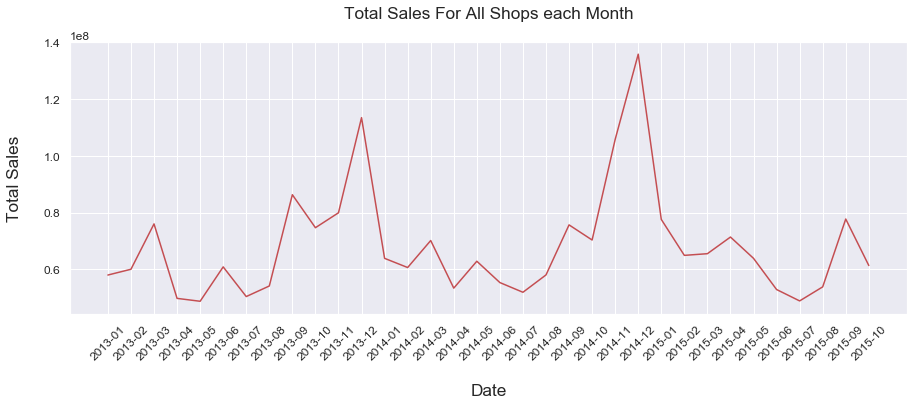

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=total_sales_per_month.index, y='total_sales', data=total_sales_per_month, color='r')
ax.set(xlabel="\nDate",
       ylabel="Total Sales\n",
       title="Total Sales For All Shops each Month\n")
plt.xticks(rotation = 45)

plt.show()


In [15]:
by_categories = combined.groupby(['category_id', 'category_name']).agg({'total_sales' : np.sum})
reind_cat = by_categories.sort_values('total_sales', ascending=False).reset_index()
top_20_cats = reind_cat.iloc[:20,::]
top_20_cats.head()

,category_id,category_name,total_sales
0,19,Games - PS3,3.365856e+08
1,20,Games - PS4,3.024536e+08
2,30,PC Games - Standard Editions,2.175054e+08
3,23,Games - XBOX 360,2.155639e+08
4,40,Cinema - DVD,1.367741e+08


[]

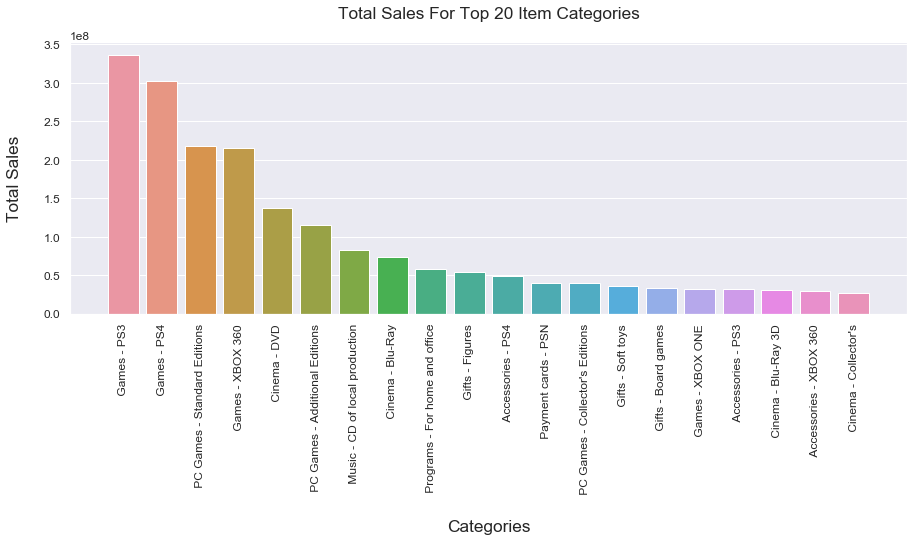

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=top_20_cats['category_name'], y=top_20_cats['total_sales'], data=top_20_cats)
ax.set(xlabel="\nCategories",
       ylabel="Total Sales\n",
       title="Total Sales For Top 20 Item Categories\n")
plt.xticks(rotation = 90)
plt.plot()

In [27]:
top_20_total_cats = sum(top_20_cats['total_sales'])
rest_total_cats = sum(combined.groupby(['category_name', 'category_id']).agg({'total_sales' : np.sum})\
.sort_values('total_sales', ascending=False).reset_index().iloc[20:,::]['total_sales'])
pie_labels = ['Top 20 Categories', 'All Other Categories']

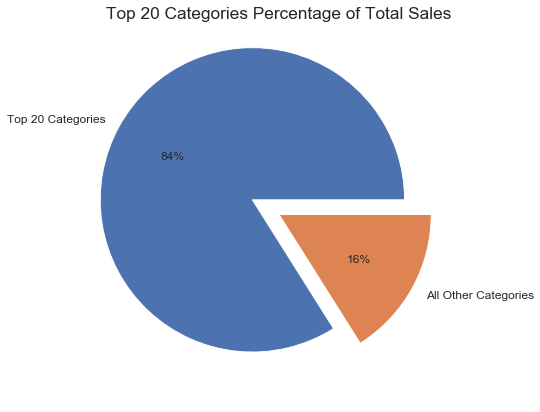

In [30]:
fig, ax = plt.subplots(figsize=(7, 7))
w = plt.pie([top_20_total_cats, rest_total_cats], labels=pie_labels, explode=[.2,0], autopct='%1.0f%%')
plt.title('Top 20 Categories Percentage of Total Sales')
plt.show(w)

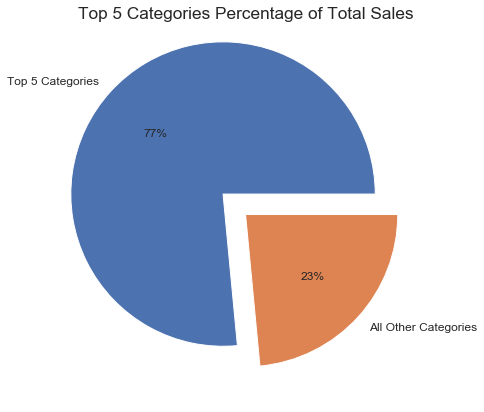

In [39]:
top_5_cats = reind_cat.iloc[:5,::]
top_5_total_cats = sum(top_10_cats['total_sales'])
piee_labels = ['Top 5 Categories', 'All Other Categories']
fig, ax = plt.subplots(figsize=(7, 7))
q = plt.pie([top_10_total_cats, rest_total_cats], labels=piee_labels, explode=[.2,0], autopct='%1.0f%%')
plt.title('Top 5 Categories Percentage of Total Sales')
plt.show(q)

In [43]:
top_5_cats.head()

,category_id,category_name,total_sales
0,19,Games - PS3,3.365856e+08
1,20,Games - PS4,3.024536e+08
2,30,PC Games - Standard Editions,2.175054e+08
3,23,Games - XBOX 360,2.155639e+08
4,40,Cinema - DVD,1.367741e+08


In [17]:
total_sales_by_shop = combined.groupby('shop_id').agg({'total_sales' : np.sum})
total_sales_by_shop.head()

,total_sales
shop_id,
2,33921699.54
3,25390777.25
4,32540462.39
5,31173472.42
6,80993643.52


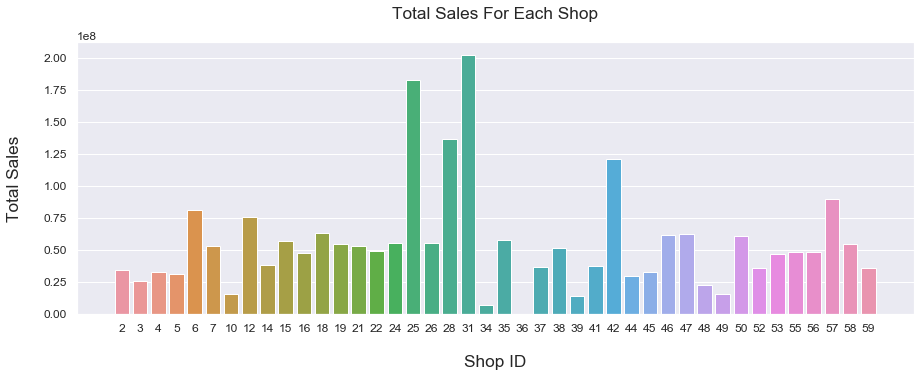

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=total_sales_by_shop.index, y=total_sales_by_shop['total_sales'])
ax.set(xlabel="\nShop ID",
       ylabel="Total Sales\n",
       title="Total Sales For Each Shop\n")
b = plt.plot()

In [19]:
top_items = combined.groupby(['item_name', 'item_id']).agg({'total_sales' : np.sum})\
.sort_values('total_sales', ascending=False).reset_index().iloc[:20,::]
top_items.head()

,item_name,item_id,total_sales
0,grand theft auto ps3 russian subtitles,3732,3.582593e+07
1,grand theft auto xbox 360 russian subtitles,3734,2.610344e+07
2,grand theft auto pc russian subtitles,3731,1.925831e+07
3,grand theft auto ps4 russian subtitles,3733,1.882065e+07
4,some us ps3 russian version,16787,1.828126e+07


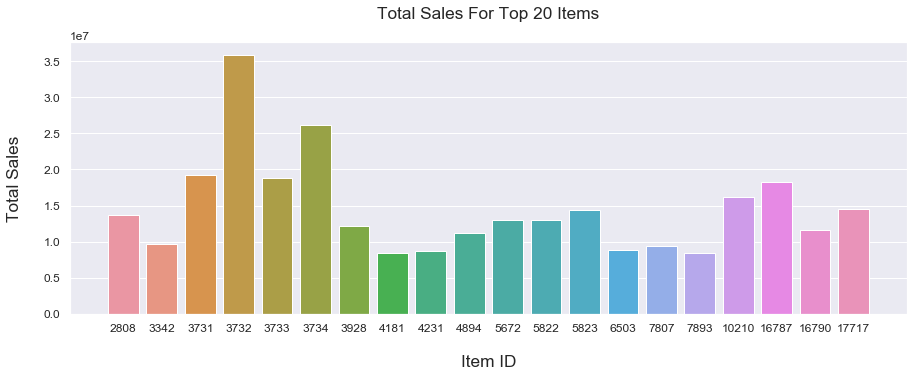

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=top_items['item_id'], y=top_items['total_sales'])
ax.set(xlabel="\nItem ID",
       ylabel="Total Sales\n",
       title="Total Sales For Top 20 Items\n")
a = plt.plot()

In [21]:
top_items.loc[top_items['item_id'].isin([3732,3734])]

,item_name,item_id,total_sales
0,grand theft auto ps3 russian subtitles,3732,3.582593e+07
1,grand theft auto xbox 360 russian subtitles,3734,2.610344e+07


In [22]:
top_20_total = sum(top_items['total_sales'])
rest_total = sum(combined.groupby(['item_name', 'item_id']).agg({'total_sales' : np.sum})\
.sort_values('total_sales', ascending=False).reset_index().iloc[20:,::]['total_sales'])
pi_labels = ['Top 20 Items', 'All Other Items']

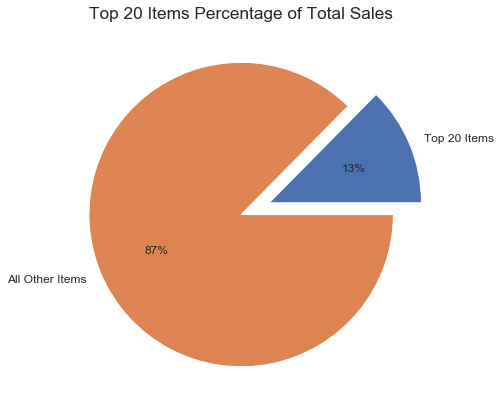

In [25]:
fig, ax = plt.subplots(figsize=(7, 7))
c = plt.pie([top_20_total, rest_total], labels=pi_labels, explode=[.2,0], autopct='%1.0f%%')
plt.title('Top 20 Items Percentage of Total Sales')
plt.show(c)